# Individual contact matrices from activities
The objective in this part is to obtain, at least for a sample of the population, the number of daily contacts with other individuals. The contacts are split into groups depending on the type of activity in which the contact happened, as well as the age of the target person.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import sklearn
from tqdm.notebook import tqdm
from time import time

sns.set_context("notebook")

## Loading data
The dataframe ```data/matsim_population_activities.csv``` contains the list of all activities for each individual based on the MATSIM simulation.

In [ ]:
activities_df = pd.read_csv('../data/matsim_population_activities.csv')
activities_df.head(10)

Let's have a look at how many unique values each column contains:

In [ ]:
unique_values_counts = pd.Series({col: activities_df[col].drop_duplicates().shape[0] for col in activities_df.columns})
sns.barplot(x=unique_values_counts.index, y=unique_values_counts.values, log=True)
plt.title('Number of unique values')
plt.show()

## Who met who ?
The problem is the following: given an individual $I\in P$, can we efficiently find the set of all individuals $I$ has been in contact
with during the day ?   
"Being in contact" here means visiting a common facility at least once.

The naive way to do this would be to obtain the list of all facilities $I$ visited, and then for all such facilities check for every other person
whether they have visited it. However this obliges to browse the activities of every other individual, so the total complexity is $O(A)$  
where $A$ is the number of total activities recorded. Now, we need to do this for every person in a sampled population (let's say at least 100000 people).
Considering $A \approx$ 10 million, this method isn't tractable.

Another method is to use a *presence matrix*: a matrix $M$ of shape $(|P|, N_{facilities})$ such that for any individual $i$ and facility $f$, $M_{i,f} =$ 1 if $i$ visited $f$ and 0 otherwise. Given the number of people in the population and the number of unique facilities, we'd never store the full matrix in memory.
However any person only visits a small number of facilities during the day (how many places do you visit in a single day ? Probably much fewer than a hundred). Thus $M$ is extremely **sparse** and can be efficiently stored using the CSR and CSC formats.  

Once $M$ is created under *both* CSR and CSC formats, we can retrieve the list of the people an individual $i$ met in the following manner:
* Retrieve the non-zero indices of row $i$ in the CSR matrix - those give which facilities $i$ visited.
* For each facility f:
* Retrieve the non-zero indices in col $f$ in the CSC matrix - those give which people visited $f$ during the day
* Compile the list of all people indices retrieved as such.  

Note that the final list will contain duplicates, and especially will include $i$ (since $i$ visited the same facilities as $i$..).  
For a single individual, retrieving the list of all contacts in this way is done in **constant time** $O(1)$.

**Remark**: the reason we use both CSR and CSC format is because we need to retrieve both rows and columns of the presence matrix. Each of those format allows to done one of those in constant time.

In [ ]:
# We'll need to remove the rows in which the facility is null
activities_df = activities_df[activities_df['facility'].notna()]

In [ ]:
# The facilities names are strings (such as 'home40692'), but the matrix indices
# will be integers starting at 0.
# Therefore we need to create an association between facility name and matrix
# column indices. This association is stored in a dictionnary facilities_dict.
unique_facilities = activities_df['facility'].drop_duplicates()
facilities_dict = {facility: index for index, facility in enumerate(unique_facilities)}
number_of_facilities = len(facilities_dict)

In [ ]:
# The people IDs are not strings but are not sorted and not continuous
# (especially, they don't begin at 0). Thus we'll also create an association
# person ID --> matrix row index
unique_ids = activities_df['id'].drop_duplicates()
ids_dict = {person_id: index for index, person_id in enumerate(unique_ids)}
number_of_ids = len(ids_dict)

In [ ]:
# To create the sparse matrix, we need to rows and columns of each non-zero elements
# This corresponds to obtaining the 'id' and 'facility' columns in the activities dataframe,
# and replacing the names with the associated indexes.
ids_indexes = np.array(activities_df['id'].apply(lambda person_id: ids_dict[person_id]))
facility_indexes = np.array(activities_df['facility'].apply(lambda facility: facilities_dict[facility]))

In [ ]:
# Creates the sparse matrices with the same data but under different formats
# See scipy's documentation for details
presence_matrix_csc = sparse.csc_matrix((np.full(activities_df.shape[0], 1), (ids_indexes, facility_indexes)))
presence_matrix_csr = sparse.csr_matrix(presence_matrix_csc)

In [ ]:
presence_matrix_csr.shape

In [ ]:
def find_contacts(person_id):
    """
    Returns the IDs of all people a person met during
    the day.
    :person_id: int64, ID of the person who's contacts should be
        retrieved.
    :return: C, F where:
        - C is the list of IDs of all contacts over a day
        - F is the list of facility names at which each contact happened
        For example, C=[10003] F=["home4095"] means a single contact happened
        with person 10,003, at facility "home4095".
        The final list most likely contains duplicates and includes in the
        contacts person_id themselves.
    """
    # Retrieves the person's index in the presence matrix's
    # rows
    person_indx = ids_dict[person_id]
    # Retrieves the indexes in the presence matrix's columns
    # of the facilities the person visited
    activ_indexes = presence_matrix_csr[person_indx].indices
    
    # Will contain the indexes of all contacts
    contacts_indexes = []
    # Will contain the indexes of the facilities at which the contacts happened
    facilities_indxs = []
    for activ_indx in activ_indexes:
        # For each facility F
        # Retrieves the indexes in the presence matrix's column
        # corresponding to F
        # of the people who were at F at least once
        # during the day (i.e. non-zero elements of column F)
        new_contacts = list(presence_matrix_csc[:, activ_indx].indices)
        contacts_indexes += new_contacts
        facilities_indxs += [activ_indx for _  in new_contacts]
    return (np.array([unique_ids.iloc[indx] for indx in contacts_indexes]),
            np.array([unique_facilities.iloc[indx] for indx in facilities_indxs]))

## Building the contact matrix
The first step is to obtain for a sample of the population the list of all contacts as well as where (in which facility) they took place.

### Selecting a sample of IDs
Building the contact matrices for all people (around 2M) would take *some time*. Thus we only select a sample of the population:

In [ ]:
sample_size = 100000
sample_ids = activities_df['id'].sample(sample_size)

### Fetching the contacts

In [ ]:
# For every person in the sample, retrieves the list of all people
# they met as well as where they met them
all_contacts, all_facilities, all_ids = [], [], []
start_time = time()

for i, person_id in enumerate(sample_ids):
    contacts, facilities = find_contacts(person_id)
    all_contacts.append(contacts)
    all_facilities.append(facilities)
    all_ids.append([person_id for _ in contacts])
    if i % 5000 == 0:
        print(f"Processed {i + 1} ids in {time() - start_time: 1.2f}s")

In [ ]:
contact_dataframe = pd.DataFrame({'id': np.concatenate(all_ids),
                                  'contact_id': np.concatenate(all_contacts),
                                  'facility': np.concatenate(all_facilities)})

In [ ]:
contact_dataframe.iloc[:-20]

What we wanna do now is:
* Replace the contact ids with the age of the contacts
* Replace the facility names with their activity types  

While each person has a unique age, facilities might be of multiple types.

### Fetching the activity types

In [ ]:
facilities_types = activities_df[['facility', 'type']]

In [ ]:
nb_types = facilities_types.drop_duplicates().groupby('facility').count()
nb_types.hist()

Some facilities (about 200,000) are counted into 2 or 3 types.  
For facilities that are counted multiple times, we'll chose the types in which they are most often represented. For example, if the facility is a school listed in 3 activities, once as 'work' (by a teacher) and twice as 'education' (by students) then the facility will **always** be considered as "education".  
This reasoning creates a proportion of mistakes, such as teachers going to school for an "educational" activity. Nonetheless this method has the advantage of being possible to do in practice regarding computation time.

In [ ]:
# Counts the occurences of each (facility, activity type) pair in the activities,
# and sort them by facility and then by type count
fac_types_counts = facilities_types.value_counts().reset_index().sort_values(['facility', 0], ascending=False)
fac_types_counts.head()

In [ ]:
# For facility, selects the pair (facility, type) that occurs most times
final_fac_types = fac_types_counts.groupby('facility').first().reset_index()[['facility', 'type']].set_index('facility')
final_fac_types.head()

In [ ]:
# For each activity in the contacts dataframe, fetches the facility type based on the previous
# result
contact_dataframe = contact_dataframe.merge(final_fac_types, left_on='facility', right_index=True)
contact_dataframe.sample(10)

### Fetching the contact's age
All we need now to obtain the contact matrices is to retrieve the age of each contact in the contacts df.

In [ ]:
population_data = pd.read_csv('../data/matsim_population_attributes.csv')
population_data.head()

In [ ]:
# Fetches the id-age association
id_age_df = population_data[['id', 'age']].drop_duplicates().set_index('id')
id_age_df.index.is_unique

In [ ]:
contact_dataframe = contact_dataframe.merge(id_age_df, left_on='id', right_index=True)
contact_dataframe.sample(10)

### Some stats
Distribution of the number of total contacts:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
nb_contacts = contact_dataframe.groupby('id').count()['contact_id']
ax[0].hist(nb_contacts, bins=100)
ax[0].set_xlabel("Number of contacts")
ax[0].set_ylabel("Frequency")
ax[1].hist(nb_contacts, bins=100, log=True)
ax[1].set_ylabel("Log(frequency)")
ax[1].set_xlabel("Number of contacts")

The number of contacts seems to follow a power law: most people only meet around a few hundred people per day, while some meet up to more than 2000.

### Contact matrix for a single indiv

#### Age to age groups
Let's now map the age of each contact to an age group.

In [ ]:
age_intervals = pd.DataFrame({'From': [0, 20, 65], 'To': [19, 64, 150], 'Group':['0-19', '19-64', '65-']})
age_intervals

In [ ]:
age_intervals = age_intervals.set_index(pd.IntervalIndex.from_arrays(age_intervals['From'], 
                                                             age_intervals['To']))['Group']

contact_dataframe['age_group'] = contact_dataframe['age'].map(age_intervals)
contact_dataframe.sample(10)

#### Counting contacts per (ID, type, age_group)

In [ ]:
contact_counts = contact_dataframe.groupby(['id', 'type', 'age_group']).count()['contact_id'].reset_index()
contact_counts = contact_counts.rename({'contact_id': 'contacts'}, axis=1)
contact_counts.sample(10)

In [ ]:
contact_counts = contact_counts.pivot(index='id', columns=['type', 'age_group'], values='contacts').fillna(0).sort_index(axis=1)
contact_counts.head()

Each row of the ```contact_counts``` dataframe contains the number of contacts for a person in the sample, for each age group and each type of activity.  
We'll now convert this to a 3D np array: dimension 0 is the person, dimensions 1 and 2 are the contact matrix itself.

In [ ]:
# Converts the dataframe into a 2D matrix (a copy of the df, each row is an individual)
contact_matrices = contact_counts.to_numpy(dtype=int)

In [ ]:
n_age_groups = age_intervals.shape[0]
# Retrieves the number of unique activity types
n_actv_types = contact_counts.columns.get_level_values(0).unique().shape[0]
print(f'Found {n_age_groups} age groups, {n_actv_types} activity types')

In [ ]:
# Reshapes the matrix into 3D such that:
# contact_matrices[i] is the 2D contact matrix for person i
# contact_matrices[i] is of shape (n_age_groups, n_activity_types)
contact_matrices = contact_matrices.reshape((contact_matrices.shape[0], n_age_groups, n_actv_types), order='F')
print(contact_matrices.shape)

### Saving the data

In [ ]:
# Multiindex column names are not well supported in the CSV format
# so we flatten them before saving the csv
contact_counts.columns = ['_'.join(col).strip() for col in contact_counts.columns.values]
contact_counts.to_csv('../data/contact_counts.csv')

In [ ]:
# Saves the 3D contact matrices array
np.save("../data/contact_matrices.npy", contact_matrices)
# Saves the IDs of people whose contact matrices are included
np.save('../data/contact_matrices_ids.npy', contact_counts.index.to_numpy())

# Predicting contacts from socio-economic factors
Now that we have the contact matrices for a sample of the population, identified via the IDs, we can build a model to estimate these matrices based on the socio-economic factors that are available for these people.

## Loading the socio-economic data

In [1]:
%matplotlib inline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_context("notebook")

/home/clement/.conda/envs/covid/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Loads the socio-eco data
wave = 1
soc_eco_df = pd.read_csv(f'../data/soc_eco_df_infected_muni_wave{wave}.csv')
soc_eco_df.head()

<ipython-input-2-f87abe866b17>:3: DtypeWarning: Columns (48,49,52,53,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  soc_eco_df = pd.read_csv(f'../data/soc_eco_df_infected_muni_wave{wave}.csv')


,Unnamed: 0.1,Unnamed: 0,id,age,bikeAvailability,carAvail,employed,hasLicense,home_x,home_y,...,PEV/PCS,PVL,PBD,PST,PES,SmallRightParties,rich,poor,female,interactemployed_poor
0,0,137601,17639,54.0,FOR_ALL,always,1,yes,2678057.0,1240960.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
1,1,137076,14698,50.0,FOR_ALL,always,1,yes,2677809.0,1241089.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
2,2,137081,14703,46.0,FOR_ALL,always,1,yes,2677660.0,1240972.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
3,3,137082,14708,33.0,FOR_ALL,always,1,yes,2678099.0,1241037.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
4,4,137085,14719,67.0,FOR_ALL,always,0,yes,2677672.0,1241175.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,0,1,1,1


### Checking the data types

A warning tells us that some columns have mixed data types:

In [3]:
# Check the names of the problematic columns
wrong_cols = [48, 49, 52, 53, 65, 66]
wrong_cols_names = soc_eco_df.columns[wrong_cols]
wrong_cols_names

Index(['TotalEmplois', 'Employement1Sector', 'TotalEtablissement',
       'Etablissement1Sector', 'PBD', 'PST'],
      dtype='object')

In [4]:
# Let's have a look at all values that appear in column 52
pd.unique(soc_eco_df.iloc[:, 52])

array(['281', '105', '1267', 'X', '491', '1500', '1414', 1414, 1737,
       '1737', '1396', '263', '647', '45057', 45057, 7166, '7166', '463',
       '470', '299', '599', '2648', '404', '448', '223', '2396', 2396,
       384, 743, 148, 1256, 403, 661, 1112, 1050, 367, 450, 159, 290, 185,
       325, 651, 212, 941, 409, 296, 683, 1105, 271, 288, 417, 277, 337,
       124, 395, 289, 272, 603, 56, 555, 223, 327, 247, 79, '79', '116',
       '245', '132', '267', '335', '269', '319', '125', '166', '257',
       '187', 187, 221, 254, 340, 226, 204, 291, 252, 118, 347, 214, 88,
       119, 184, 233, 477, 176, 201, 101, 168, 70, '70', '84', '123',
       '186', '262', '162', '565', '324', '213', '129', '89', '99', '68',
       '95', '183', '126', '158', '277', '256', '360', '139', '77', '260',
       '401', '154', '220', '94', '195', '235', '167', '199', '97', '200'],
      dtype=object)

It appears that some entries are entered as strings but actually contain an integer. Some entries also contain characters like * or X which most likely indicate
missing values.  
The following tries to convert the values to integers, and replace them with NaNs otherwise.

In [5]:
def string_int_to_int(string_int):
    """
    Converts an integer contained in a string into a real integer.
    If the conversion fails, returns NA.
    """
    try:
        res = int(string_int)
        return res
    except ValueError:
        return np.nan

In [6]:
# apply the function to each problematic column
for col in wrong_cols_names:
    soc_eco_df[col] = soc_eco_df[col].apply(string_int_to_int)

The question is, can we remove the resulting NaN values ? We first need to check how many rows include NaNs:

In [7]:
uncomplete_rows = soc_eco_df[soc_eco_df.isna().any(axis=1)]
uncomplete_rows

,Unnamed: 0.1,Unnamed: 0,id,age,bikeAvailability,carAvail,employed,hasLicense,home_x,home_y,...,PEV/PCS,PVL,PBD,PST,PES,SmallRightParties,rich,poor,female,interactemployed_poor
7898,7898,130800,123691,59.0,FOR_ALL,always,1,yes,2689192.0,1253853.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,0,1,1,1
7899,7899,130723,123347,62.0,FOR_NONE,always,1,yes,2688614.0,1253197.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,0,1
7900,7900,130588,122625,61.0,FOR_ALL,sometimes,0,yes,2688681.0,1252235.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,1,0
7901,7901,130590,122642,20.0,FOR_SOME,sometimes,0,no,2688914.0,1252826.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,1,0
7902,7902,130591,122643,26.0,FOR_SOME,always,0,yes,2688914.0,1252826.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270051,270051,292228,2295887,50.0,FOR_ALL,always,1,yes,2658652.0,1272284.0,...,1.194722,3.914051,2.0,NaN,5.786377,0.436876,0,0,0,1
270052,270052,292232,2295907,69.0,FOR_NONE,always,0,yes,2658735.0,1270248.0,...,1.194722,3.914051,2.0,NaN,5.786377,0.436876,1,0,0,0
270053,270053,292235,2295911,49.0,FOR_ALL,always,1,yes,2657384.0,1269639.0,...,1.194722,3.914051,2.0,NaN,5.786377,0.436876,1,0,0,1
270054,270054,294820,2294803,50.0,FOR_ALL,always,1,yes,2657207.0,1268719.0,...,1.194722,3.914051,2.0,NaN,5.786377,0.436876,1,0,0,1


In [8]:
len(soc_eco_df)

270056

It appears that 152,000 rows out of 270,000 contain NaN values. Thus it would be very costly to remove them as it would reduce the amount of data available but also potentially create biases linked to how the missing values were distributed. Thus it is safer to just remove the problematic columns.

In [9]:
soc_eco_df = soc_eco_df.drop(wrong_cols_names, axis=1)

No null values are left in the dataset and the dtypes seem in order.


### Column names
Some columns need to be renamed to avoid confusions or remove special characters, such as in 'PopDensityPer_km²':

In [10]:
soc_eco_df = soc_eco_df.rename({'PopDensitiyPer_km²':'PopDensity', 'TotSurfacePer_km²':'TotSurface'}, axis=1)

### Useless columns
The first two columns are linked to the way the data was created but are no longer of any use, so we might as well remove them:

In [11]:
soc_eco_df = soc_eco_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

## Preprocessing

### Checking for null values

In [12]:
na_cols_counts = soc_eco_df.isna().sum()
print(na_cols_counts[na_cols_counts > 0])

SocialSecurityRate    1147
dtype: int64


The "SocialSecurityRate" variable is missing for 1147 people. Out of of 270k it might seem like we could discard them, but this could induce a bias in the data..  
For now, we'll discard the entire column (so we won't use that feature for any prediction), however a better method in the future is to predict the missing values based on the other variables.

In [13]:
soc_eco_df = soc_eco_df.drop('SocialSecurityRate', axis=1)

### Discarding the geographical features
The data includes some variables that give geographical information about the individuals. This information is necessarily correlated with the
infections as those were introduced into the synthetic population based on the incidence in every *municipality*.

Thus we cannot include those features in the models if we want to search for a relationship between the other features and infections.

In [14]:
geographical_features = ['home_x', 'home_y', 'Lat', 'Lon', 'lat_lon', 'postcode', 'MuniZIP', 'MuniZIP_x', 'MuniZIP_y',]
geo_features_df = soc_eco_df[geographical_features]
soc_eco_df = soc_eco_df.drop(geographical_features, axis=1)

**Note**: another possibility than discarding those features would be to use a spatial linear model, such as Geographically Weighted Regressions (GWR) or Spatial Lag Models (SLM).

### Converting categorical features to one-hot

In [15]:
# Selects the columns whose values are categorical
categorical_features = soc_eco_df.select_dtypes('object')
categorical_features.head()

,bikeAvailability,carAvail,hasLicense,municipalityType,sex,ov_guteklasse
0,FOR_ALL,always,yes,urban,f,D
1,FOR_ALL,always,yes,urban,f,D
2,FOR_ALL,always,yes,urban,f,D
3,FOR_ALL,always,yes,urban,f,D
4,FOR_ALL,always,yes,urban,f,C


In [16]:
categorical_features_onehot = pd.get_dummies(categorical_features)
# Let's have a look at all possible values that we obtain for those features
categorical_features_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270056 entries, 0 to 270055
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   bikeAvailability_FOR_ALL   270056 non-null  uint8
 1   bikeAvailability_FOR_NONE  270056 non-null  uint8
 2   bikeAvailability_FOR_SOME  270056 non-null  uint8
 3   carAvail_always            270056 non-null  uint8
 4   carAvail_never             270056 non-null  uint8
 5   carAvail_sometimes         270056 non-null  uint8
 6   hasLicense_no              270056 non-null  uint8
 7   hasLicense_yes             270056 non-null  uint8
 8   municipalityType_rural     270056 non-null  uint8
 9   municipalityType_suburban  270056 non-null  uint8
 10  municipalityType_urban     270056 non-null  uint8
 11  sex_f                      270056 non-null  uint8
 12  sex_m                      270056 non-null  uint8
 13  ov_guteklasse_A            270056 non-null  uint8
 14  ov_g

In [17]:
# Replaces the original categorical features in the full dataset with their one-hot versions
# we just computed:
soc_eco_df = soc_eco_df.drop(categorical_features.columns, axis=1)
soc_eco_df = pd.concat([soc_eco_df, categorical_features_onehot], axis=1)

We obtain a dataset ready to be used for statistical analysis.

## Statistical Analysis

### Contact - soc/eco factors relationship
Here we hope to predict the contact matrices of an individual based on their socio-economic position.  
The first test we'll perform is an ordinary least-squares linear regression with only a few features as input:  
age, sex, Pop65, Pop20, PopDulation density  
Except for the 'female' feature which is binary, we'll use the log of the variables so that their distribution is less skewed.

In [18]:
# Drops the 'infected' column as this isn't our predicted variable here
infected = soc_eco_df['infected']
soc_eco_df = soc_eco_df.drop('infected', axis=1)
soc_eco_data = soc_eco_df.drop('id', axis=1)

### PCA of soc-eco factors
We'll use a PCA to try to distinguish potential clusters in the data:

In [19]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [20]:
# Performs PCA onto the soc/eco features to reduce them to 2d
soc_eco_pca = PCA(n_components=5, random_state=42)
soc_eco_scaler = StandardScaler()
soc_eco_scaler.fit(soc_eco_data)
scaled_soc_eco_data = soc_eco_scaler.transform(soc_eco_data)

soc_eco_pca.fit(scaled_soc_eco_data)
pca_transform = soc_eco_pca.transform(scaled_soc_eco_data)

# Applies GMM clustering to better visualize the clusters and use
# them for further analysis
pca_gmm = GaussianMixture(n_components=2, random_state=42).fit(pca_transform)
pca_clusters = pca_gmm.predict(pca_transform)

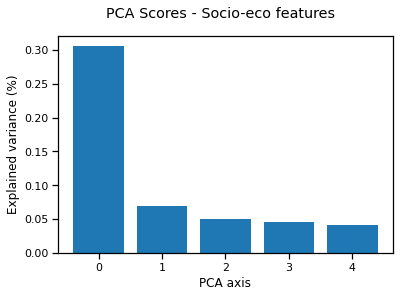

In [21]:
# Prints the explained variance for each component
plt.bar(x=np.arange(soc_eco_pca.components_.shape[0]), height=soc_eco_pca.explained_variance_ratio_)
plt.xlabel('PCA axis')
plt.ylabel('Explained variance (%)')
plt.suptitle("PCA Scores - Socio-eco features")
plt.savefig("../figures/pca_soc_eco_variance.png")
plt.show()

Given that axis 0 explains a lot more of the total variance than the following axes, we can expect the data to be clustered along this single dimension.  
We can visualize the first two axes to hope to see those clusters:

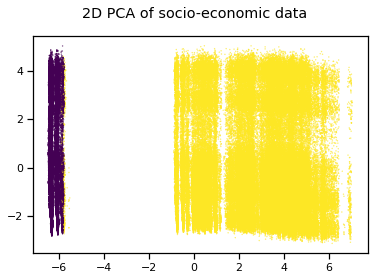

In [22]:
plt.scatter(pca_transform[:, 0], pca_transform[:, 1], c=pca_clusters, s=0.1)
plt.suptitle("2D PCA of socio-economic data")
plt.savefig("../figures/pca_soc_eco_2d.png")
plt.show()

There are two clear clusters isolated by axis 0. Let's have a look at the important features:

In [23]:
def pca_features_ranking(fitted_pca, feature_names, pca_axis=0):
    """
    Given a PCA axis, returns the coefficient of each feature
    in that axis, ranked by importance.
    """
    features_ranking_indices = np.argsort(np.abs(fitted_pca.components_[pca_axis]))[::-1]
    features_ranking = pd.Series({feature: coef
                    for feature, coef in zip(feature_names[features_ranking_indices],
                                             fitted_pca.components_[0][features_ranking_indices])
                   }, name=f"PCA axis {pca_axis} coefs").rename_axis('Feature coef')
    return features_ranking

In [24]:
pca_features_ranking(soc_eco_pca, soc_eco_data.columns.values).head(15)

Feature coef
Employement2Sector                 -0.219604
Etablissement2Sector               -0.217819
NbrResident                        -0.216270
PrivateHouseholds                  -0.216261
Employement3Sector                 -0.216013
PopDensity                         -0.215894
Etablissement3Sector               -0.215643
TotSurface                         -0.215448
HabInfraSurface_VariationHa        -0.210218
PES                                -0.208412
AgriSurface_VariationHa             0.207528
Pop20                              -0.200137
MeanSizeHouseholdsPerPerson         0.194639
HabitationInfrastructureSurface%   -0.194295
UDC                                 0.190458
Name: PCA axis 0 coefs, dtype: float64

Clearly the most important features are those related to the **municipality** (variables that are equal for all individuals living within the same muni).  
We thus need to have a look at the distribution of municipalities:

In [25]:
muni_populations = geo_features_df['MuniZIP'].value_counts().sort_values(ascending=False)
print(f"Found {muni_populations.shape[0]} unique munis")

Found 138 unique munis


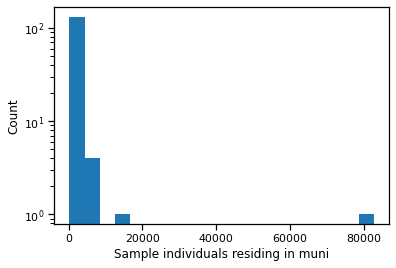

In [26]:
plt.hist(muni_populations.values, bins=20, log=True)
plt.xlabel('Sample individuals residing in muni')
plt.ylabel('Count')
plt.savefig("../figures/munis_pop_hist.png")
plt.show()

In [27]:
muni_populations.head()

261     82728
3203    16339
243      6038
4001     4652
62       4457
Name: MuniZIP, dtype: int64

While the large majority of munis include less than 10K residents in the sample, two municipalities include respectively 16k and 82k residents.  Let's examine their postcodes so that we can know which cities those are:

In [28]:
zip_postcode_pairs = geo_features_df[['MuniZIP', 'postcode']].drop_duplicates('MuniZIP')
zip_postcode_pairs[zip_postcode_pairs['MuniZIP'].isin([261, 3203])]

,MuniZIP,postcode
40520,261,8004
123248,3203,9000


Quite expectedly, the two major cities are **Zürich** (postcodes 8000) and **St-Gallens** (postcodes 9000).  
Let's verify that the clusters indeed separate residents from Zürich from the rest of the population:

In [29]:
# Creates a column indicating if individuals live in Zurich, St-Gallens or some other muni
munis_cluster_ids = {261: 0, 3203: 1}
def map_muniZIP_cluster_id(muniZIP):
    if muniZIP in munis_cluster_ids:
        return munis_cluster_ids[muniZIP]
    else:
        return 2

zurich_indicator = pd.to_numeric(geo_features_df['MuniZIP'].apply(map_muniZIP_cluster_id))

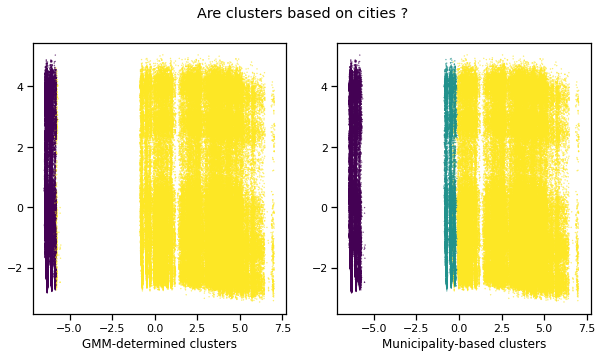

In [30]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(pca_transform[:, 0], pca_transform[:, 1], c=pca_clusters, s=0.1)
plt.xlabel("GMM-determined clusters")
plt.subplot(122)
plt.scatter(pca_transform[:, 0], pca_transform[:, 1], c=zurich_indicator, s=0.1)
plt.xlabel("Municipality-based clusters")
plt.suptitle("Are clusters based on cities ?")
plt.savefig("../figures/pca_cities.png")
plt.show()

**Conclusion**:  

The boolean variable "Lives in Zürich", which is not event present in the features, makes by far the most difference between the individuals.

### PCA of contact matrices
We'll now study the distribution of contact matrices, perhaps to discover similar clusters as within the socio-economic data.

In [31]:
# Loads the contacts dataframe
contacts_df = pd.read_csv('../data/contact_counts.csv')
contacts_df.head()

,id,education_0-19,education_19-64,education_65-,home_0-19,home_19-64,home_65-,leisure_0-19,leisure_19-64,leisure_65-,service_0-19,service_19-64,service_65-,shop_0-19,shop_19-64,shop_65-,work_0-19,work_19-64,work_65-
0,227,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,24.0,0.0,0.0,7.0,0.0
1,239,0.0,0.0,0.0,0.0,2.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0
2,272,166.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,276,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,314,0.0,0.0,0.0,0.0,5.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0


In [32]:
# Drops the ID as it shouldn't be used as a feature
contacts_data = contacts_df.drop('id', axis=1)

# Performs PCA onto the soc/eco features to reduce them to 2d
contacts_pca = PCA(n_components=5, random_state=42)
contacts_scaler = StandardScaler()
contacts_scaler.fit(contacts_data)
scaled_contacts_data = contacts_scaler.transform(contacts_data)

contacts_pca.fit(scaled_contacts_data)
pca_contacts_transform = contacts_pca.transform(scaled_contacts_data)

# Applies GMM clustering to better visualize the clusters and use
# them for further analysis
pca_contacts_gmm = GaussianMixture(n_components=3, random_state=42).fit(pca_contacts_transform)
pca_contacts_clusters = pca_contacts_gmm.predict(pca_contacts_transform)

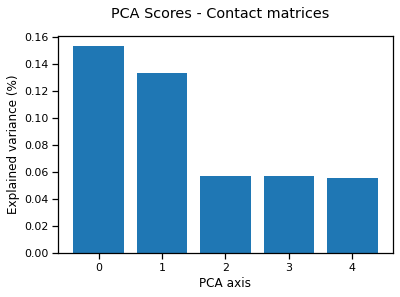

In [33]:
# Prints the explained variance for each component
plt.bar(x=np.arange(contacts_pca.components_.shape[0]), height=contacts_pca.explained_variance_ratio_)
plt.xlabel('PCA axis')
plt.ylabel('Explained variance (%)')
plt.suptitle("PCA Scores - Contact matrices")
plt.savefig("../figures/pca_contacts_variance.png")
plt.show()

This time, the first two clusters explain a similar portion of the variance. We can thus hope for the data to be clustered in a 2D projection:

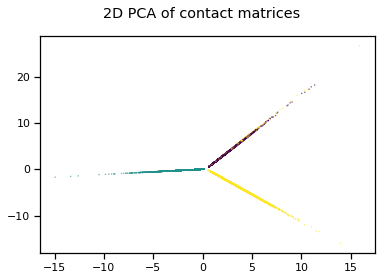

In [34]:
plt.scatter(pca_contacts_transform[:, 0], pca_contacts_transform[:, 1], c=pca_contacts_clusters, s=0.1)
plt.suptitle("2D PCA of contact matrices")
plt.savefig("../figures/pca_contacts_2d.png")
plt.show()

Let's take a detailed look at the clusters. We'll print the average contacts per activity type and contact age in each cluster:

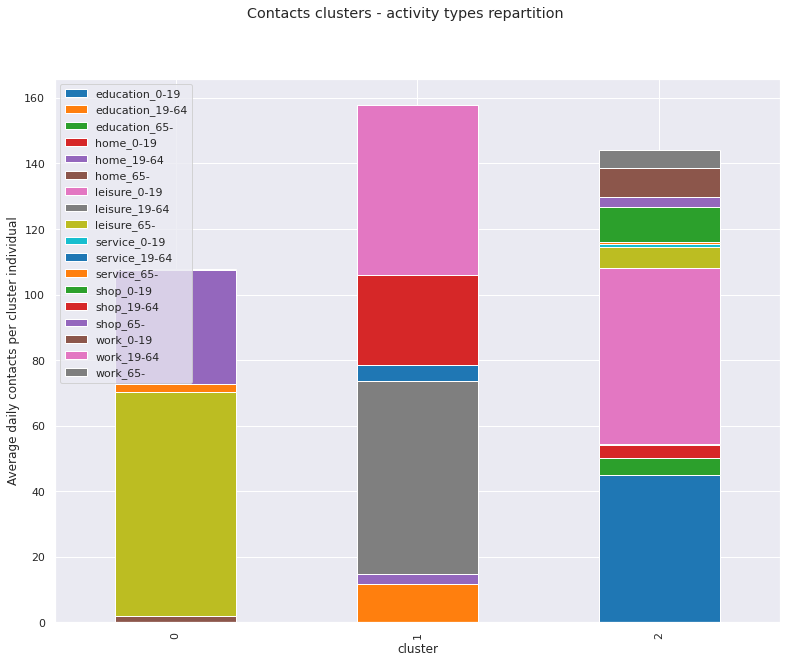

In [35]:
# Computes the average for each entry of the contacts matrices, grouped by clusters
contacts_data['cluster'] = pca_contacts_clusters
avg_cluster_contacts = contacts_data.groupby('cluster').mean()

with sns.axes_style('darkgrid'):
    avg_cluster_contacts.plot.bar(stacked=True, figsize=(13, 10))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.suptitle("Contacts clusters - activity types repartition")
    plt.ylabel("Average daily contacts per cluster individual")
    plt.savefig("../figures/contact_clusters.png")
    plt.show()

**Conclusions**:  

* People in cluster 0 only contact people over 65, mostly at leisure and shop but also at service and home activities. No contacts are made at work activities. This heavily points towards retired people.
* People in cluster 2 make most of their contacts with people of age 0-19, at activities of type education, leisure, shop and work. They also have contacts with people over 65, at activities education, shop and work.
* People in cluster 1 make all of their contacts with people in ages 19-64 at activities of education, leisure, shop and work.

Overall, it **seems that the contact matrices are clustered by the person's age**, which isn't surprising.  
The consequence of that is that a model to predict the contact matrices from the socio-economic data would probably benefit from being split into three sub-models, one for each age group.

### Merging the dataframes
We'll now merge the contacts dataframe (which gives for a sample of the population the contact matrices) and the socio-economics dataframe.  
We then hope to predict the former based on the latter.  
Naturally we need a sufficient amount of individuals to be present in both datasets so that the merged one contains enough values to perform
a meaningful analysis.

The following three cells prepare sub-dataframes ```X``` and ```y``` for feature selection and ML tasks:

In [36]:
merged_df = soc_eco_df.merge(contacts_df, on="id")
merged_df.shape

(12825, 83)

In [37]:
X = merged_df[soc_eco_df.columns].drop('id', axis=1)
print(X.shape, X.dtypes)

(12825, 64) age                float64
employed             int64
householdIncome    float64
isCarPassenger        bool
ptHasGA               bool
                    ...   
sex_m                uint8
ov_guteklasse_A      uint8
ov_guteklasse_B      uint8
ov_guteklasse_C      uint8
ov_guteklasse_D      uint8
Length: 64, dtype: object


In [38]:
y = merged_df[contacts_df.columns].drop('id', axis=1)
print(y.shape, y.dtypes)

(12825, 18) education_0-19     float64
education_19-64    float64
education_65-      float64
home_0-19          float64
home_19-64         float64
home_65-           float64
leisure_0-19       float64
leisure_19-64      float64
leisure_65-        float64
service_0-19       float64
service_19-64      float64
service_65-        float64
shop_0-19          float64
shop_19-64         float64
shop_65-           float64
work_0-19          float64
work_19-64         float64
work_65-           float64
dtype: object


#### Is the sample representative ?
The socio-economic data were taken from the first 270,000 people in the MATSIM output. Depending on how those people are ordered in the XML file, this might induce a bias.  
We previously used a 2d-PCA to visualize clusters within the socio-economic data. We can now visualize the locations of the people in the joined datasets on those two axes to assess whether their repartition is similar to that of the full 270,000 people.

In [39]:
scaled_X = soc_eco_scaler.transform(X)

In [40]:
sample_pca = soc_eco_pca.transform(scaled_X)
sample_pca.shape

(12825, 5)

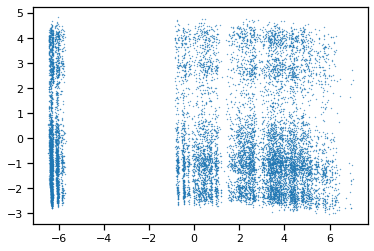

In [41]:
plt.scatter(sample_pca[:, 0], sample_pca[:, 1], s=0.1)
plt.savefig("../figures/sample_soc_eco_pca_2d.png")
plt.show()

### Feature selection and regression
The socio-economic dataframe contains over 60 features. Many of them are most likely correlated, and thus it is naturally a good idea to isolate a smaller set of features to be used as predictors for the regression.  

#### Baseline model

In [42]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from matplotlib.gridspec import GridSpec

In [43]:
# Sets a random seed that should be used everywhere throughout the notebook,
# for the sake of reproducibility
_RANDOM_SEED_ = 42
# The usual train-test split. We shuffle the data as the order of the individuals
# might not be actually random.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=_RANDOM_SEED_)

In [44]:
def test_model(X, y, n_folds=5, model_builder=LinearRegression, use_scaler=True, verbose=False):
    """
    Given a set of features, optimizes a model 
        inputs --> c
    for every entry c in the contact matrix.
    :param X: 2D array / df, input data (predictors).
    :param y: 1D array / df, target data.
    :param n_folds: int, cross-validation folds to use.
    :param model_builder: function to call to build the model, which
        must implement fit() and score() (e.g. LinearRegression())
    :param use_scaler: bool, whether to scale the data before
        applying the model.
    """
    # Scales the input data if required
    if use_scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    
    # For each category (eg "leisure_0-19"), we estimate the model's performance
    # via cross-validation
    categories, score = [], []
    for category, contacts in y.items():
        if verbose:
            print("Evaluating model for category ", category)
        model = model_builder()
        cv_scores = cross_val_score(model, X, contacts, cv=n_folds)
        categories.append(category)
        score.append(cv_scores)
    return pd.DataFrame({
        'category': categories,
        'score': score
    }).explode('score')

Let's compare the performances of the linear regression (LR) and Random Forest regressor (RF), when *all* features are used:

In [45]:
max_rf_depth = 1
def build_rf():
    return RandomForestRegressor(max_depth=max_rf_depth)

# Compiles the cv scores for the linear regression
baseline_lr_scores = test_model(x_train, y_train, model_builder=LinearRegression)
# adds a column 'model' which is always 'LR', this will be used for plotting with seaborn
baseline_lr_scores['model'] = ['LR'] * baseline_lr_scores.shape[0]
# Same for the random forest
baseline_rf_scores = test_model(x_train, y_train, model_builder=build_rf)
baseline_rf_scores['model'] = [f'RF depth={max_rf_depth}'] * baseline_rf_scores.shape[0]
# Concats both models' results into a single DataFrame
baseline_scores = pd.concat([baseline_lr_scores, baseline_rf_scores], axis=0)

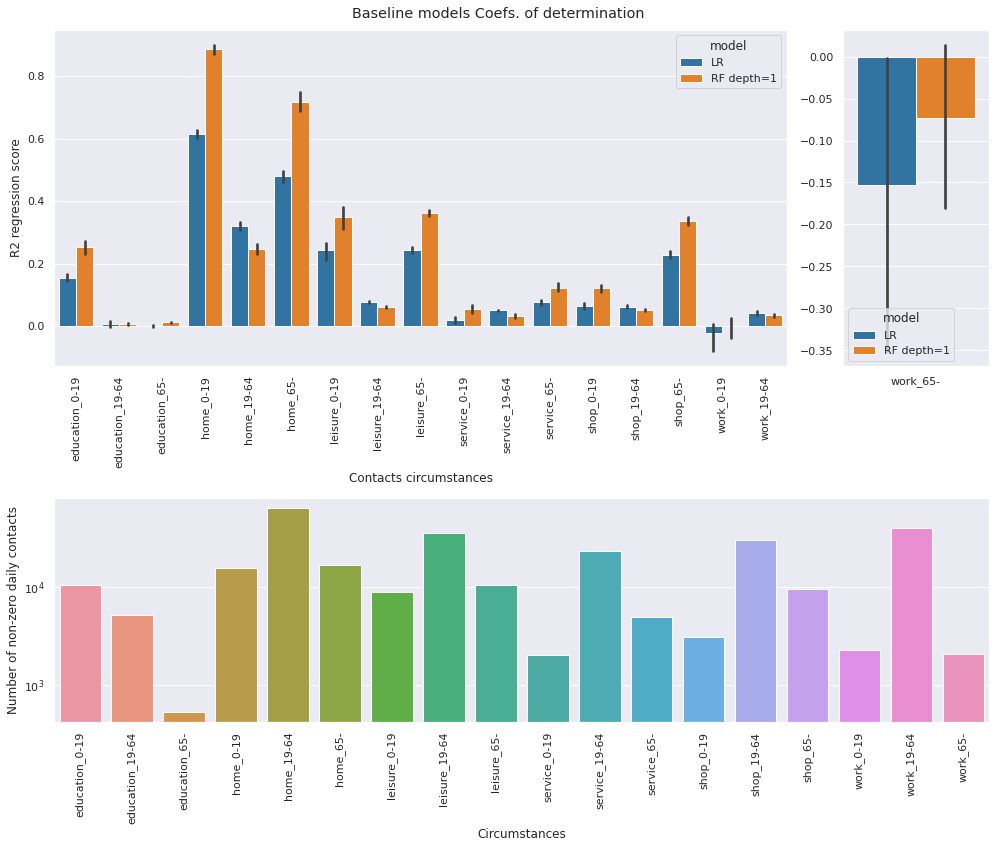

In [46]:
plt.figure(figsize=(14, 12))
with sns.axes_style("darkgrid"):
    # Creates a layout of two subplots with a specific width ratio. 
    # The left-side subplot will show the score for each category and for each model,
    # except for category 'work_65-' because they're much worse than the
    # rest
    gs = GridSpec(nrows=2, ncols=2, width_ratios=[5, 1], height_ratios=[3, 2])
    plt.subplot(gs[0, 0])
    sns.barplot(data=baseline_scores[baseline_scores['category'] != 'work_65-'],
                x="category", y="score", hue="model")
    plt.xticks(rotation=90)
    plt.suptitle("Baseline models Coefs. of determination")
    plt.ylabel("R2 regression score")
    plt.xlabel("Contacts circumstances")

    plt.subplot(gs[0, 1])
    sns.barplot(data=baseline_scores[baseline_scores['category'] == 'work_65-'],
                x="category", y="score", hue="model")
    plt.ylabel('')
    plt.xlabel('')

    plt.subplot(gs[1, :])
    melted_contacts = contacts_df.melt(id_vars='id', value_vars=contacts_df.columns.values,
                                       var_name="category", value_name='contacts')
    nonzero_contacts = melted_contacts[melted_contacts['contacts'] != 0].groupby('category').count().reset_index()
    sns.barplot(data=nonzero_contacts, x="category", y="contacts", log=True)
    plt.xticks(rotation=90)
    plt.ylabel("Number of non-zero daily contacts")
    plt.xlabel("Circumstances")

    plt.tight_layout()
    plt.savefig("../figures/baseline_models_scores.png")
    plt.show()

#### Features mutual correlation
Since we have so many features, many are probably inter-correlated. We might want to check the Pearson coefficient for each pair of feature. For that a heatmap is convenient:

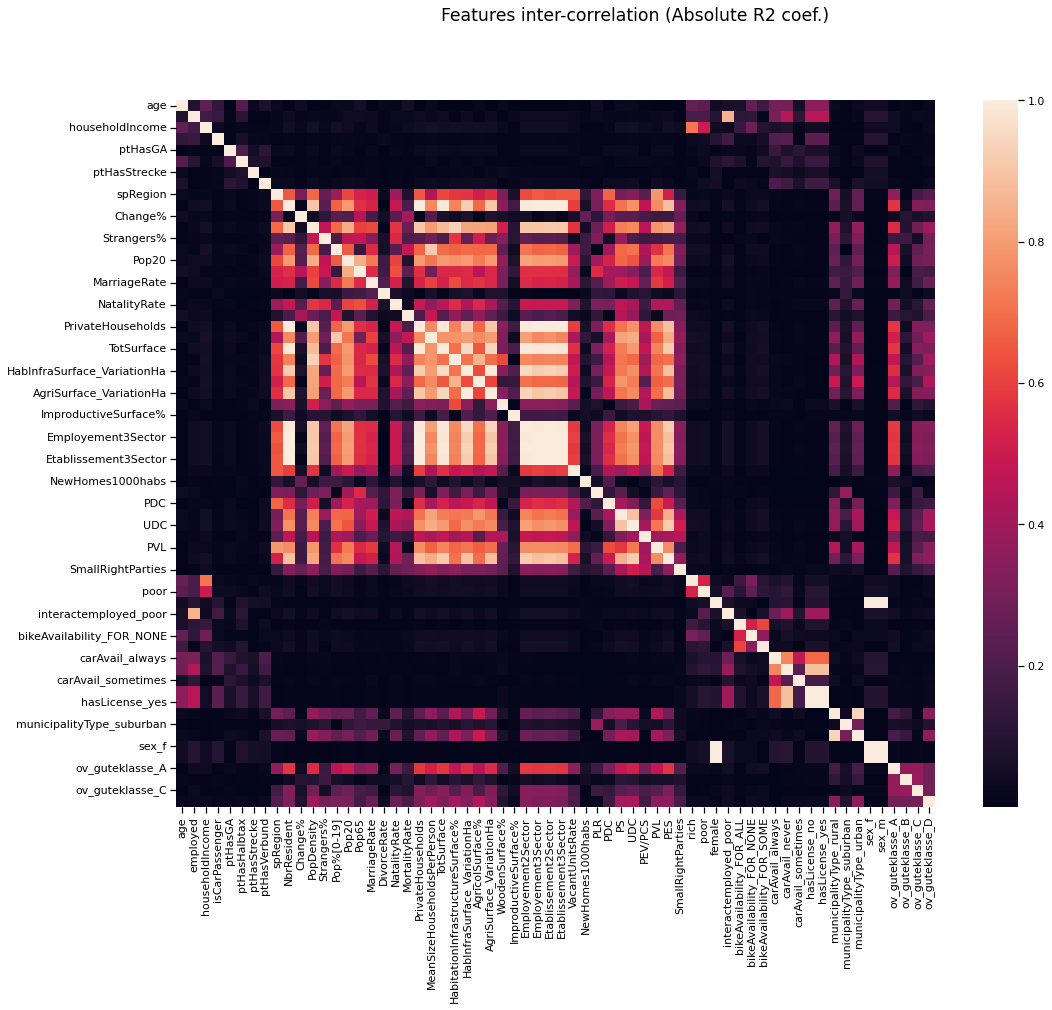

In [47]:
plt.figure(figsize=(17, 13))
plt.suptitle("Features inter-correlation (Absolute R2 coef.)", fontsize="x-large")
features_corr = X.corr()
sns.heatmap(np.abs(features_corr))
plt.savefig("../figures/inter_correlation.png")
plt.show()

#### Random Forest Regressive Feature Elimination

In [48]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor